In [41]:
import pandas as pd
import numpy as np
from scipy import stats as stats
from scipy import interpolate
import sklearn
from matplotlib import pyplot as plt
import regex
import statsmodels.api as sm
import pickle

In [42]:
df=pd.read_pickle('Final_Train.pkl')
with open('variable_org','rb') as f:
    variable_org=pickle.load(f)
    pass

target=variable_org['target']
dense_factors=variable_org['dense']
sparse_factors=variable_org['sparse']
category_factors=variable_org['categorical']
ordinal_factors=variable_org['ordinal']
other_factors=variable_org['other']

In [3]:
df[target+dense_factors].corr()['price']

price             1.000000
sqft_living       0.694384
sqft_outside      0.076741
percent_above    -0.138359
sqft_living15     0.597030
sqft_outside15    0.068597
age              -0.053388
Name: price, dtype: float64

How about the correlation matrix of all our dense factors.

In [6]:
corrs=df[dense_factors].corr()
corrs

,sqft_living,sqft_outside,percent_above,sqft_living15,sqft_outside15,age
sqft_living,1.000000,0.172987,-0.208717,0.760565,0.170093,-0.321947
sqft_outside,0.172987,1.000000,0.032826,0.170758,0.790179,-0.055836
percent_above,-0.208717,0.032826,1.000000,-0.035126,0.031297,-0.197491
sqft_living15,0.760565,0.170758,-0.035126,1.000000,0.187659,-0.327377
sqft_outside15,0.170093,0.790179,0.031297,0.187659,1.000000,-0.067725
age,-0.321947,-0.055836,-0.197491,-0.327377,-0.067725,1.000000


<ipython-input-7-6c2a641601de>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dense_factors)


[Text(-1.0, 0, 'sqft_living'),
 Text(0.0, 0, 'sqft_outside'),
 Text(1.0, 0, 'percent_above'),
 Text(2.0, 0, 'sqft_living15'),
 Text(3.0, 0, 'sqft_outside15'),
 Text(4.0, 0, 'age'),
 Text(5.0, 0, ''),
 Text(6.0, 0, '')]

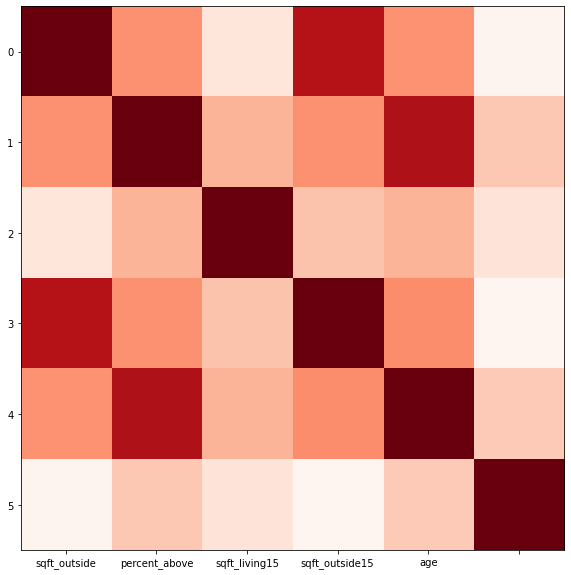

In [7]:
fig,ax=plt.subplots(figsize=(10,10))
im=ax.imshow(corrs,cmap='Reds')
ax.set_xticklabels(dense_factors)

Let's compare sale prices for the four seasons.

In [8]:
winter=df[df.season=='Winter'].price
fall=df[df.season=='Fall'].price
summer=df[df.season=='Summer'].price
spring=df[df.season=='Spring'].price

In [9]:
df.groupby(['season']).price.agg(['mean','std','count']).round(2)

,mean,std,count
season,,,
Fall,527.00,347.59,5026
Spring,550.07,353.72,6471
Summer,542.66,343.24,6303
Winter,519.28,348.32,3667


In [10]:
stats.f_oneway(winter,fall,summer,spring)

F_onewayResult(statistic=8.128692559355823, pvalue=2.0880396895263044e-05)

At a significance level of 0.01, there is evidence to reject.

Next let's look at renovation status

In [11]:
df.groupby(['renovation_status']).price.agg(['mean','std','count']).round(2)

,mean,std,count
renovation_status,,,
10-24,849.98,543.88,258
2-4,751.77,442.44,35
25+,604.22,447.88,226
5-9,878.50,608.00,107
Never,529.84,339.23,20730
Recent,658.79,320.32,111


We will exclude the houses that were never renovated to avoid issues of homogeneity.

In [12]:
frames=()
for status in df.renovation_status.unique():
    if(status!='Never'):
        frames+=(df[df.renovation_status==status].price,)
    else:
        pass
print(len(frames))

5


In [13]:
stats.f_oneway(*frames)

F_onewayResult(statistic=10.321693611985523, pvalue=3.899675814868449e-08)

In [15]:
never=df[df.renovation_status=='Never'].price
renovated=df[df.renovation_status!='Never'].price

In [16]:
two_way_comp=pd.DataFrame([renovated.agg(['mean','std','count']),never.agg(['mean','std','count'])])
two_way_comp.index=['renovated','never']
two_way_comp

,mean,std,count
renovated,745.299943,505.858603,737.0
never,529.836053,339.232485,20730.0


Let's look at the sale price organized by zip code.

In [25]:
zipcode_pricing=df.groupby(['zipcode']).price.agg(['count','mean'])
zipcode_pricing

,count,mean
zipcode,,
98001,359,280.881192
98002,199,234.284035
98003,280,294.111279
98004,313,1317.549856
98005,168,810.289696
...,...,...
98177,254,676.523406
98178,262,310.612756
98188,136,289.078346


In [27]:
zipcode_pricing.nlargest(10,columns=['mean'])

,count,mean
zipcode,,
98039,48,1991.770833
98004,313,1317.549856
98040,278,1170.688367
98112,268,1094.695123
98109,109,880.077752
98105,229,863.228943
98006,496,853.385887
98119,184,849.714810
98102,103,833.584447


In [31]:
zipcode_pricing.nsmallest(10,columns=['mean'])

,count,mean
zipcode,,
98002,199,234.284035
98168,268,240.407955
98032,124,251.017177
98001,359,280.881192
98148,57,284.908596
98023,495,286.011440
98188,136,289.078346
98003,280,294.111279
98030,256,296.187980


In [33]:
zipcode_pricing.sort_values(by='mean',inplace=True)

<AxesSubplot:title={'center':'Average Prices'}, xlabel='zipcode'>

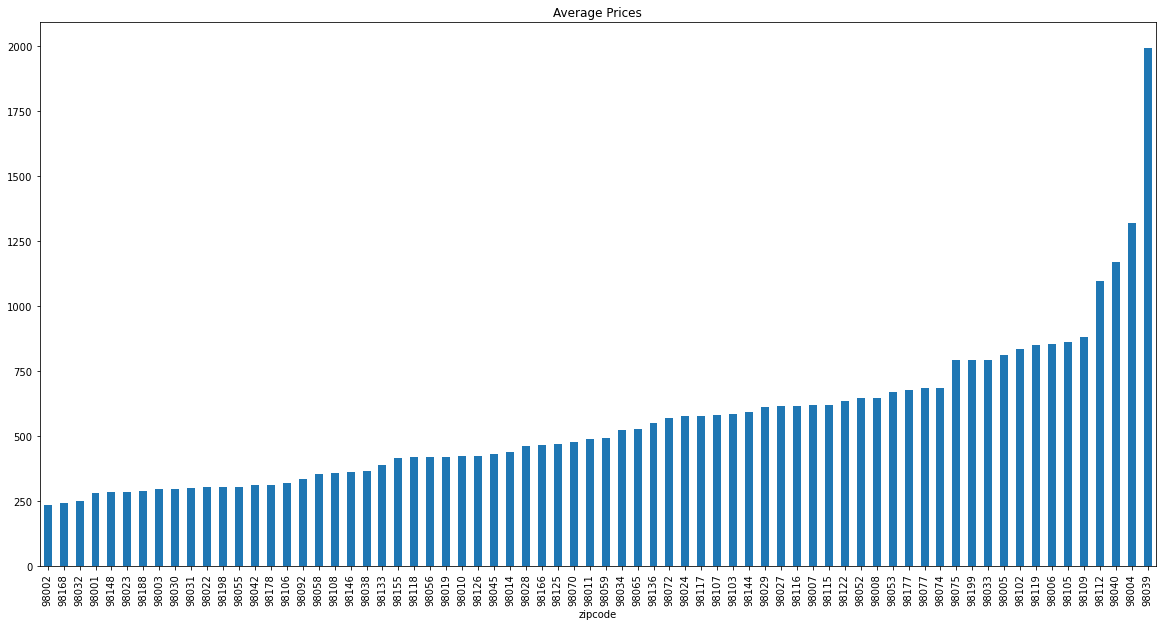

In [34]:
fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Average Prices by Zipcode')
#pd.plotting.table(ax,zipcode_pricing[['count']],loc='upper left',colWidths=[0.2,0.2])
zipcode_pricing['mean'].plot(kind='bar',ax=ax)

We can clearly see that the zip code 98039 has significantly higher sale prices than the rest.  Looking at a [map](https://www.google.com/maps/place/Medina,+WA+98039/@47.6272552,-122.2778795,13z/data=!3m1!4b1!4m5!3m4!1s0x54906b5f7bfdac91:0x36cace7c29db7076!8m2!3d47.6258071!4d-122.2421963) of the area, one can see why for qualitative reasons:  the area covered is mostly Medina, a relatively-close suburb of Seattle alongside Puget Sound.  Taking a closer look at the price differences, we can conclude that it will be reasonable to include a dummy variable to control for sales in the 98039 zipcode (done elsewhere in our notebook.)

In [35]:
Medina=df[df.zipcode==98039].price
exMedina=df[df.zipcode!=98039].price

In [36]:
two_way_comp=pd.DataFrame([Medina.agg(['mean','std','count']),exMedina.agg(['mean','std','count'])])
two_way_comp.index=['Medina Zip','Elsewhere']
two_way_comp

,mean,std,count
Medina Zip,1991.770833,816.873411,48.0
Elsewhere,533.973688,339.847552,21419.0


Given this disparity in prices, it seems important to check for any patterns in Medina.  Including waterfront properties.

In [48]:
df[df.zipcode==98039].groupby('waterfront').price.count()

waterfront
0.0    47
1.0     1
Name: price, dtype: int64

In [38]:
zipcode_sqft=df.groupby(['zipcode']).sqft_living.agg(['count','mean'])
zipcode_sqft

,count,mean
zipcode,,
98001,359,1901.743733
98002,199,1627.743719
98003,280,1928.882143
98004,313,2862.811502
98005,168,2656.803571
...,...,...
98177,254,2323.307087
98178,262,1729.351145
98188,136,1802.772059


<AxesSubplot:title={'center':'Average Space by Zipcode'}, xlabel='zipcode'>

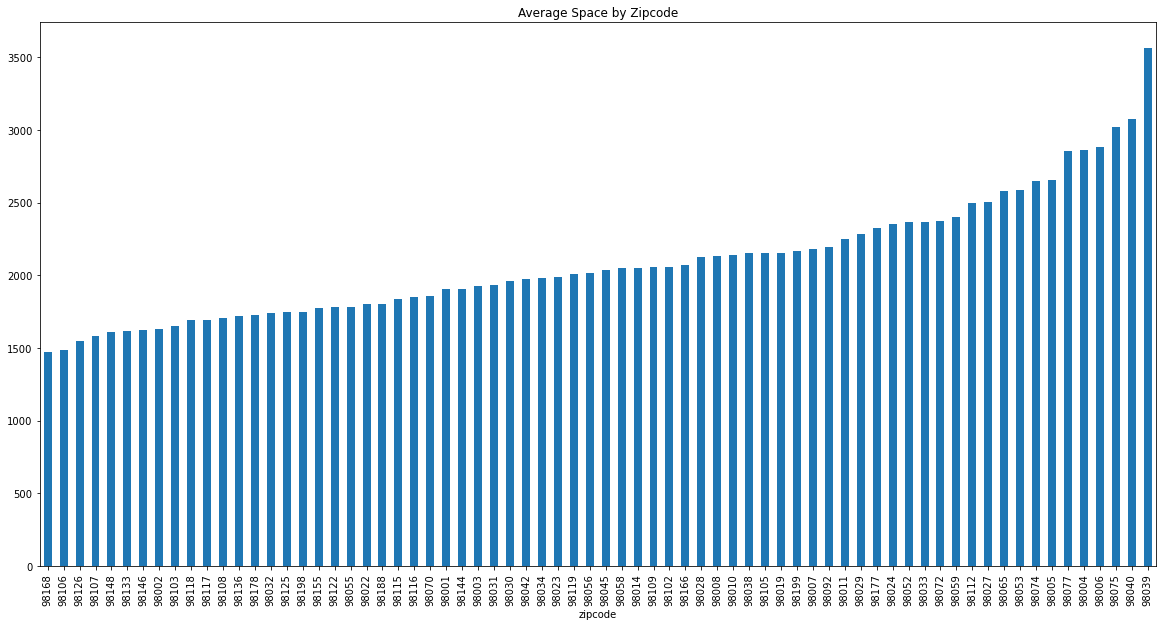

In [40]:
zipcode_sqft.sort_values(by='mean',inplace=True)
fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Average Space by Zipcode')
#pd.plotting.table(ax,zipcode_pricing[['count']],loc='upper left',colWidths=[0.2,0.2])
zipcode_sqft['mean'].plot(kind='bar',ax=ax)

While houses sold in Medina have, on average, larger areas, the difference is not as egregious.